In [2]:
import sys 
import os 

sys.path.append('../..')

DATA_DIR = '../../data'
os.environ['DATA_DIR'] = DATA_DIR

from utils.things import calc_correlation
from utils.data import load_things, load_gpt, load_cslb, load_sorting, load_mcrae, load_behav
from utils.things import match_behv_sim
from utils.feature_norms import generate_concepts_to_keep
from utils.analyses.category.category import get_categories
from utils.analyses.category.pairiwise import calc_sim, plot_violin
from utils.things import get_all_vectorized
import pandas as pd
import matplotlib.pyplot as plt 
from sklearn.metrics.pairwise import cosine_similarity
import seaborn as sns




# Load data 

In [3]:
group_to_one_concept = True
duplicates = True 
min_amount_runs_feature_occured = 4
min_amount_runs_feature_occured_within_concept = 1

feature_norms = {
    'McRae': load_mcrae(group_to_one_concept, duplicates),
    'CSLB': load_cslb(group_to_one_concept),
    'GPT3-davinci-McRae': load_gpt(min_amount_runs_feature_occured, group_to_one_concept, min_amount_runs_feature_occured_within_concept, duplicates, "mcrae_priming", "gpt3-davinci"),
    'ChatGPT3-McRae': load_gpt(min_amount_runs_feature_occured, group_to_one_concept, min_amount_runs_feature_occured_within_concept, duplicates, 'mcrae_priming', 'chatgpt-gpt3.5-turbo')
    }

things_df = load_things()
intersection_concepts = generate_concepts_to_keep(feature_norms, 'intersection')
feature_norms_vec, behav_sim_matched = get_all_vectorized(feature_norms, intersection_concepts, 'count')

../../data


/home/hannes/anaconda3/envs/features/lib/python3.9/site-packages/openpyxl/worksheet/_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


317 concepts are present in all feature norms


/home/hannes/anaconda3/envs/features/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


# Predicting superordinate categories

### find overlapping categories

In [4]:
intersection_concepts = generate_concepts_to_keep(feature_norms)

317 concepts are present in all feature norms


In [5]:
things_df = things_df.rename(columns={'uniqueID': 'concept_id'})
things_df = things_df[['concept_id', 'All Bottom-up Categories']].set_index('concept_id')
things_df = things_df.loc[intersection_concepts].reset_index()

new_rows = []
for row in things_df.iterrows():
    cats = row[1]['All Bottom-up Categories'].split(',')
    for cat in cats:
        new_rows.append({'concept_id': row[1].concept_id, 'category': cat})
        
things_df = pd.DataFrame(new_rows)

things_df_count = things_df.groupby('category', as_index=False).count().sort_values(by='concept_id', ascending=False)
things_df_count

category  concept_id
87                   animal          35
127                   fruit          19
148      musical instrument          15
97                     bird          14
187                 vehicle          13
..                      ...         ...
39                   legume           1
93                 baby toy           1
92              baby animal           1
91   audio visual equipment           1
0                  abrasive           1

[195 rows x 2 columns]

In [6]:
categories, all_short_categories, animal = get_categories(things_df)

# RSA for all categories

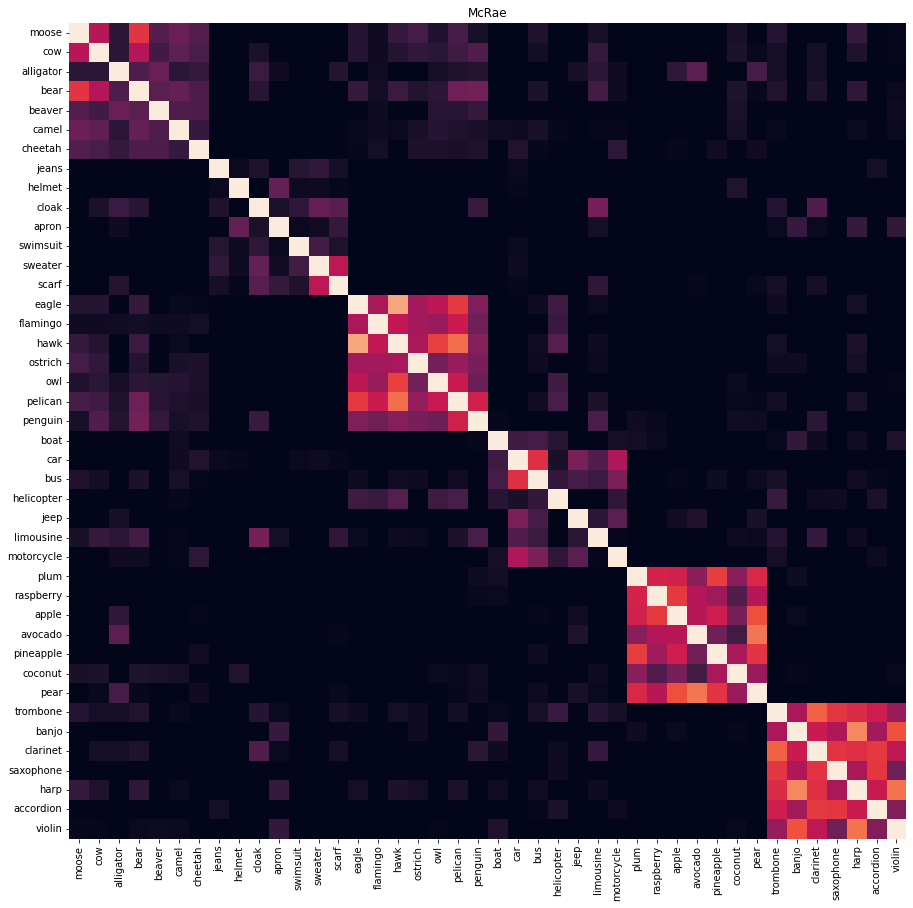

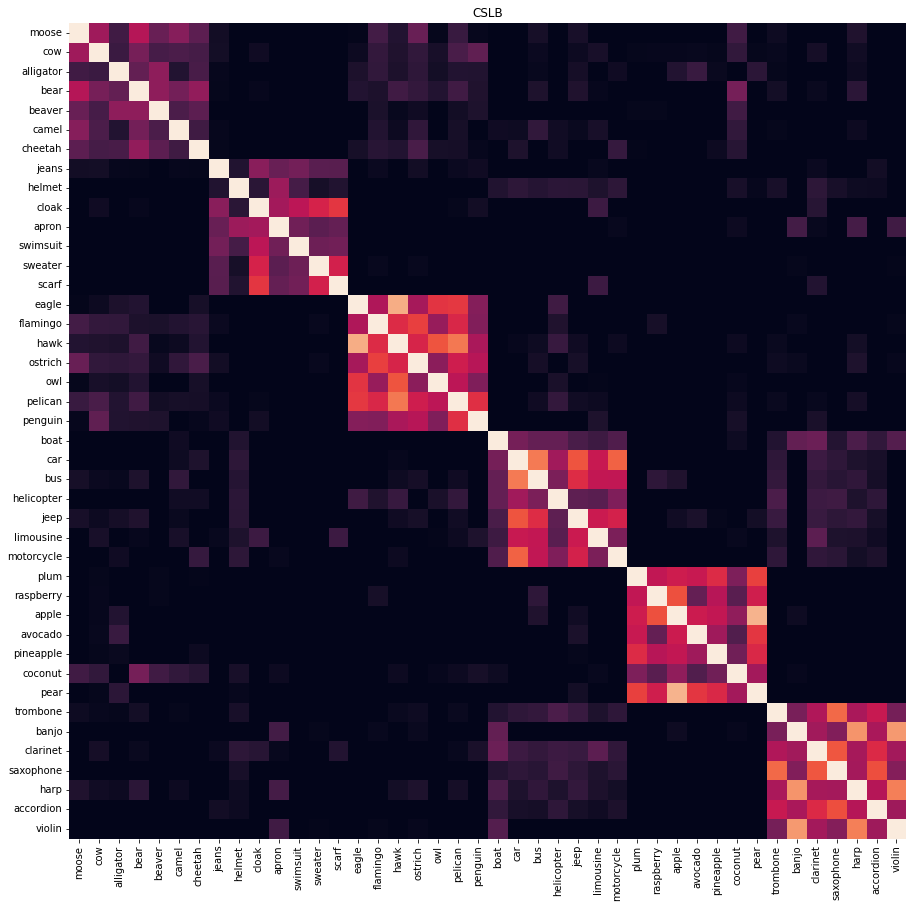

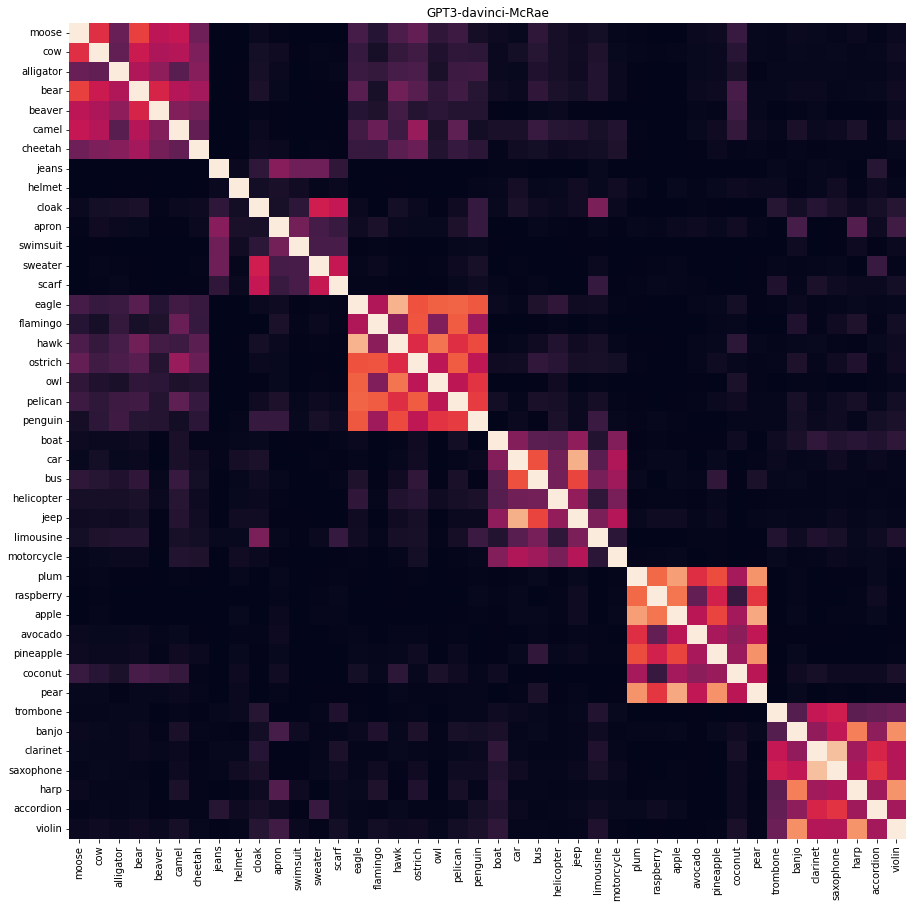

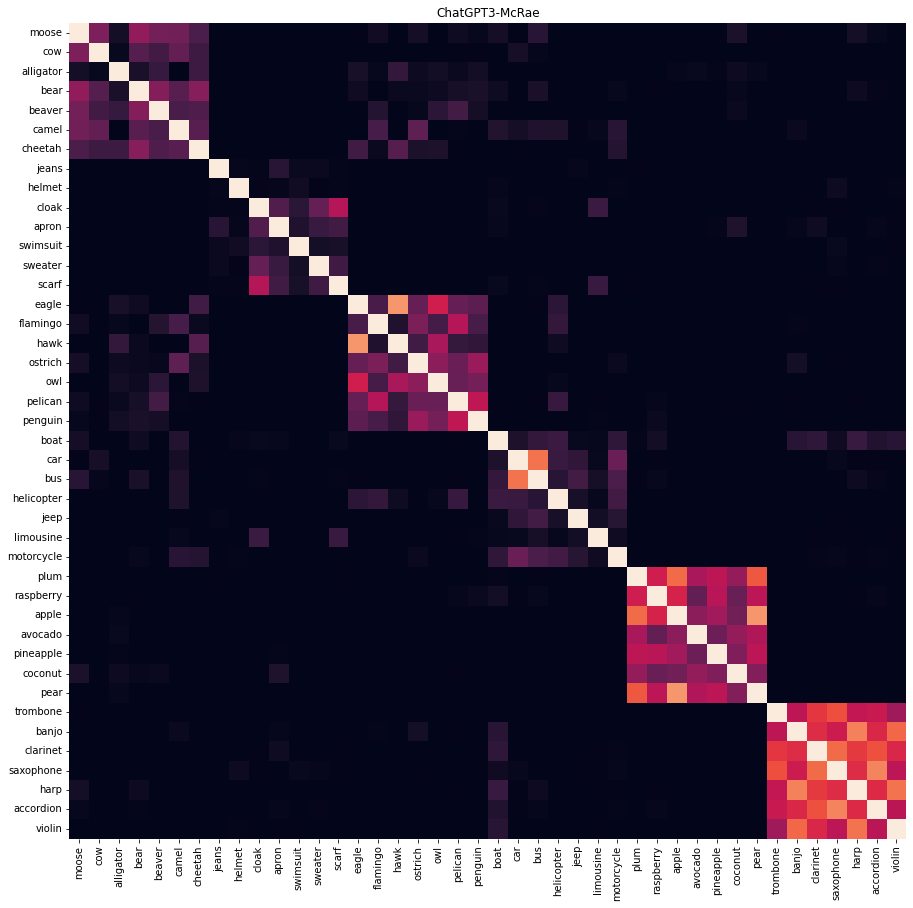

In [7]:
for feature_norm_name, feature_norm_vec in feature_norms_vec.items():
    vec_intersection = feature_norm_vec.loc[all_short_categories]
    similarities = cosine_similarity(vec_intersection, vec_intersection)
    similarities = pd.DataFrame(similarities, columns=all_short_categories, index=all_short_categories)

    fig, ax = plt.subplots(figsize=(15,15))
    sns.heatmap(similarities, ax=ax, yticklabels=True, xticklabels=True, cbar=False)
    plt.title(feature_norm_name)
    plt.savefig(f'all-catergories-{feature_norm_name}.svg')


# Clustering of Animals

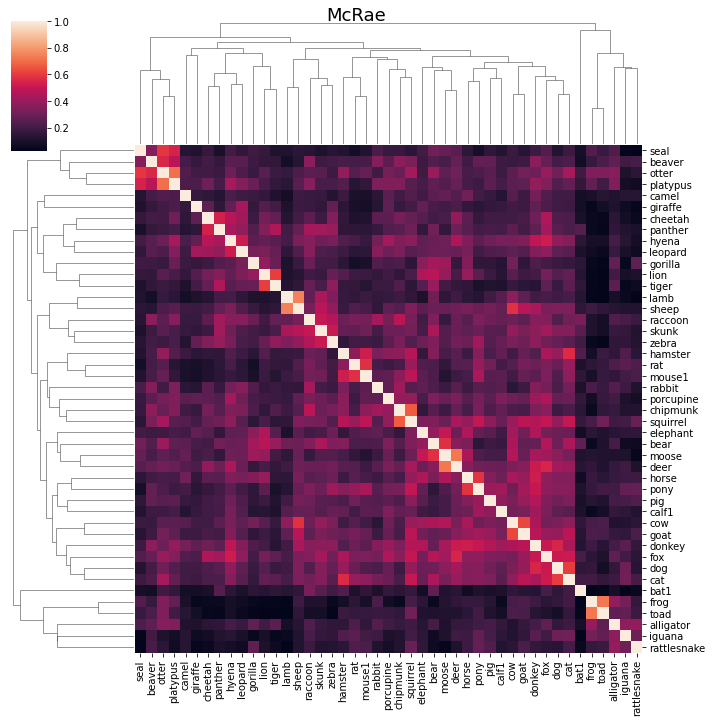

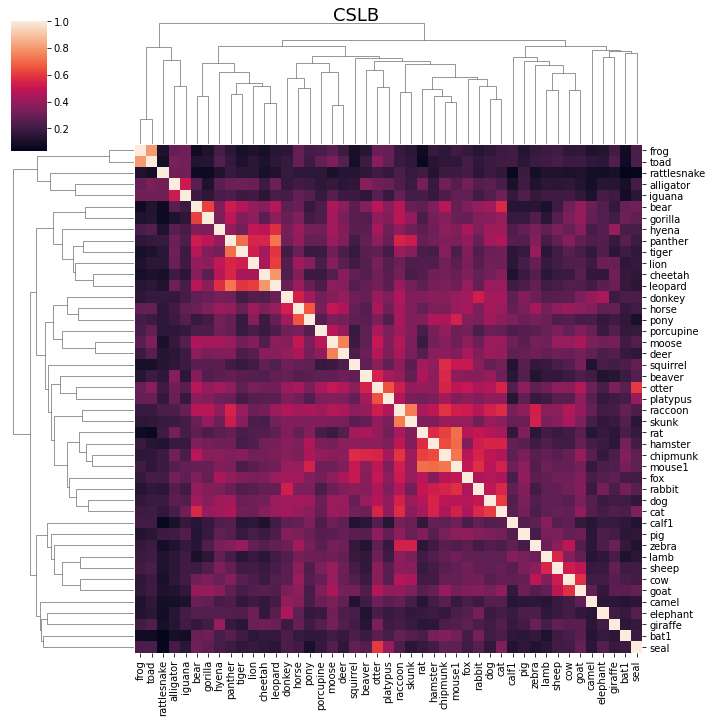

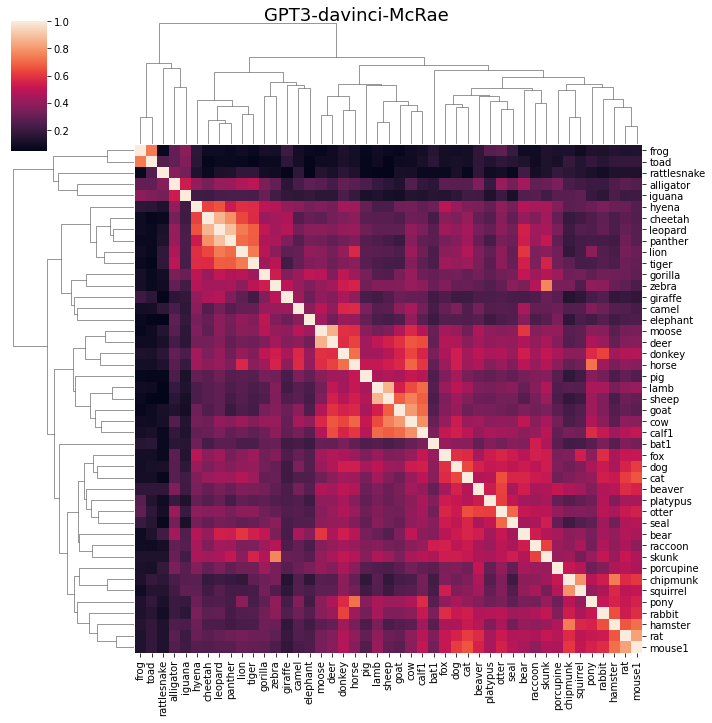

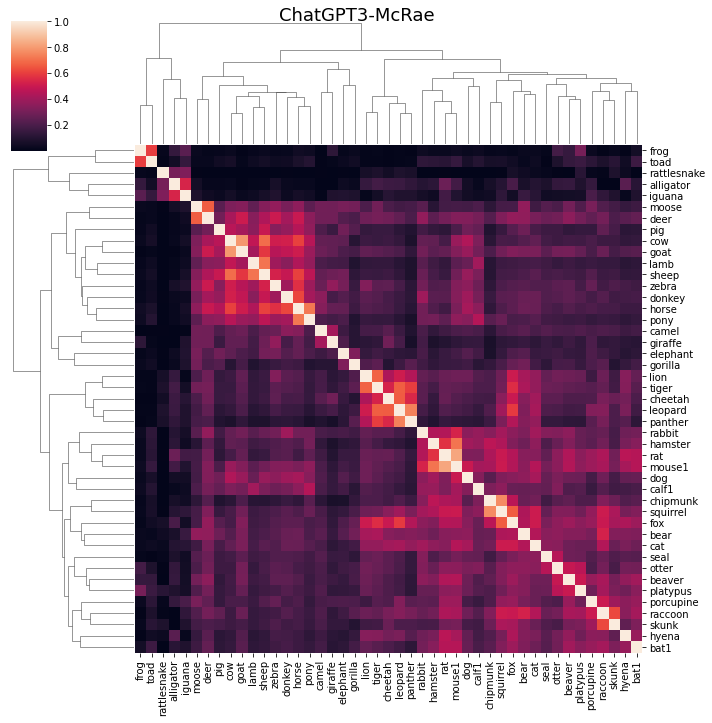

In [8]:
for feature_norm_name, feature_norm_vec in feature_norms_vec.items():
    vec_animal = feature_norm_vec.loc[animal]
    similarities = cosine_similarity(vec_animal, vec_animal)
    similarities = pd.DataFrame(similarities, columns=animal, index=animal)

    a = sns.clustermap(similarities, yticklabels=True, xticklabels=True)
    a.fig.suptitle(f'{feature_norm_name}', y=1, fontsize=18) 
    plt.savefig(f'{feature_norm_name}.svg')

# Pairwise Correlations

In [9]:
sims_gpt, sims_cslb, sims_mc = calc_sim(feature_norms_vec['GPT3-davinci-McRae'], feature_norms_vec['CSLB'], feature_norms_vec['McRae'], categories)

# TODO count/tfidf not wroking csbl mcrae

animals
moose cow ['jeans', 'helmet', 'cloak', 'apron', 'swimsuit', 'sweater', 'scarf', 'robe', 'jacket', 'dress', 'bra', 'blouse', 'belt', 'coat', 'shirt', 'eagle', 'flamingo', 'hawk', 'ostrich', 'owl', 'pelican', 'penguin', 'pigeon', 'seagull', 'swan', 'chicken1', 'turkey', 'goose', 'duck', 'boat', 'car', 'bus', 'helicopter', 'jeep', 'limousine', 'motorcycle', 'ship', 'taxi', 'tractor', 'train', 'yacht', 'trolley', 'plum', 'raspberry', 'apple', 'avocado', 'pineapple', 'coconut', 'pear', 'prune', 'grapefruit', 'lemon', 'banana', 'grape', 'orange', 'tomato', 'strawberry', 'peach', 'lime', 'cherry', 'blueberry', 'trombone', 'banjo', 'clarinet', 'saxophone', 'harp', 'accordion', 'violin', 'trumpet', 'guitar', 'piano', 'drum', 'tuba', 'harmonica', 'flute', 'cello']
moose cow ['jeans', 'helmet', 'cloak', 'apron', 'swimsuit', 'sweater', 'scarf', 'robe', 'jacket', 'dress', 'bra', 'blouse', 'belt', 'coat', 'shirt', 'eagle', 'flamingo', 'hawk', 'ostrich', 'owl', 'pelican', 'penguin', 'pigeon',

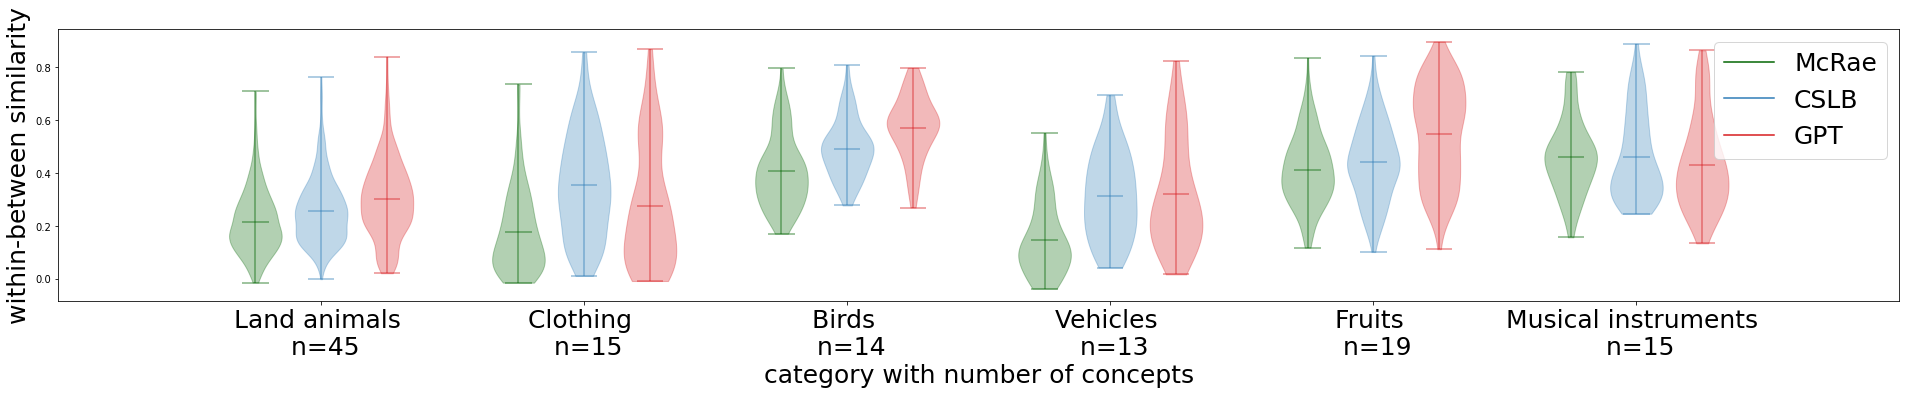

In [10]:
fig, axes = plt.subplots(1,1, figsize=(33,5), sharex=True)

plot_violin(axes, sims_gpt, sims_cslb, sims_mc, categories)
plt.savefig('pairwise_similarities.svg')


### Correlation with THINGS on categories

In [11]:
for category, category_concepts, category_plot_name in categories:
    print(f'Category: {category}')
    gpt_vec_cat = feature_norms_vec['GPT3-davinci-McRae'].loc[category_concepts]
    gpt_sim = cosine_similarity(gpt_vec_cat, gpt_vec_cat)
    #sns.heatmap(gpt_sim, yticklabels=True, xticklabels=True)
    mc_vec_cat = feature_norms_vec['McRae'].loc[category_concepts]
    cslb_vec_cat = feature_norms_vec['CSLB'].loc[category_concepts]
    behv_sim_cat = match_behv_sim(behv_sim, category_concepts, load_sorting())
    
    sns.heatmap(behv_sim_cat, yticklabels=True, xticklabels=True)
    r_gpt_behav, r_cslb_behav, r_mc_behav, r_gpt_mc, r_cslb_gpt = calc_correlation(gpt_vec_cat, mc_vec_cat, behv_sim_cat, cslb_vec_cat, None)
    print(f'Corr GPT: {r_gpt_behav}')
    print(f'Corr CSLB: {r_cslb_behav}')
    print(f'Corr McRae: {r_mc_behav}')
    

Category: animals


NameError: name 'behv_sim' is not defined